In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

matplotlib.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from homer_preprocessing import read_homer_gene_exp, import_homer_diffgene, pull_comparisons_get_diff
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano, plot_exp_rpkm, gene_list_bar_plot

In [2]:
workingDirectory = '/home/h1bennet/brain_aging/results/00_Microglia_RNA/'
dataDirectory = '/data/mm10/Brain_MPSIIIA/RNA/Microglia/WT/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


Read in color scheme

In [56]:
hex_dict={}
rgb_dict={}
for line in open('/home/h1bennet/brain_aging/data/brain_aging_color_table.txt','r'):
    split = line.strip().replace('\ufeff','').split('\t')
    # split2 = split[1]
    hex_dict[split[0]] = split[1]
    rgb_dict[split[0]] = split[2]   

# Read in data
We will match based on refseq to make sure we are pulling the same promoter as in the tpm 

### Read in TPM from homer file with refseq ID

In [6]:
tpm = pd.read_csv('./expression/HOMER.rawTPM.txt',
                      sep='\t', index_col=0)

tpm_mat = tpm.loc[:, tpm.columns.str.contains('8week|24months|26months')]

Average tag counts

In [8]:
groups = ['rna_8weeks', 'rna_20monthPlus']
columns = [[0,1,2],
           [3,4,5]]

avg_tpm = {}

for group, col in zip(groups, columns):
    avg_tpm[group] = tpm_mat.iloc[:, col].mean(1)
    
avg_tpm_df = pd.DataFrame(avg_tpm)

## Read in H3K27Ac promoter tags (normalized)

In [9]:
from homer_preprocessing import read_annotated_peaks

In [10]:
h3k27ac_tss, mat = read_annotated_peaks('./annotatedTSS_H3K27Ac_4mo_25mo.txt')
# this is unfiltered and contains different p

# set gene name as index
# h3k27ac_tss = h3k27ac_tss.set_index('Gene Name')
# filter to matrix
h3k27ac_tss_mat = h3k27ac_tss.loc[:, h3k27ac_tss.columns.str.contains('Brain_MPSIIIA')]

Pull average tags by group

In [11]:
groups = ['h3k27ac_4month', 'h3k27ac_20monthPlus']
columns = [[0,1,2,3],
           [4,5,6]]

avg_h3k27ac = {}

for group, col in zip(groups, columns):
    avg_h3k27ac[group] = h3k27ac_tss_mat.iloc[:, col].mean(1)
    
avg_h3k27ac_df = pd.DataFrame(avg_h3k27ac)

## Merge into combined data frame for plotting

In [16]:
tpm_h3k27ac_df = pd.merge(avg_tpm_df,
                          avg_h3k27ac_df,
                          left_index=True,
                          right_index=True,
                          how='left')

In [17]:
tpm_h3k27ac_df.columns

Index(['rna_8weeks', 'rna_20monthPlus', 'h3k27ac_4month',
       'h3k27ac_20monthPlus'],
      dtype='object')

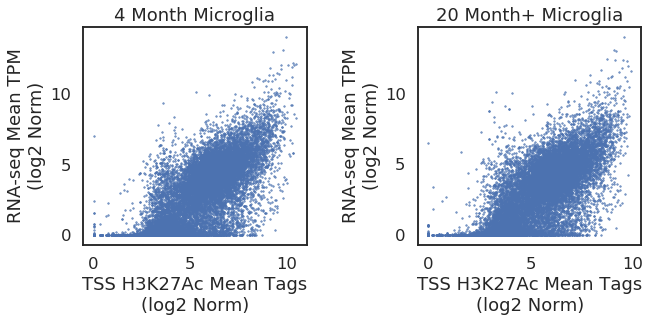

In [18]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(wspace=0.5)

axs[0].scatter(np.log2(tpm_h3k27ac_df.h3k27ac_4month+1),
           np.log2(tpm_h3k27ac_df.rna_8weeks+1),
           s=0.5)

axs[0].set_xlabel('TSS H3K27Ac Mean Tags\n(log2 Norm)');
axs[0].set_ylabel('RNA-seq Mean TPM\n(log2 Norm)');
axs[0].set_title('4 Month Microglia');

axs[1].scatter(np.log2(tpm_h3k27ac_df.h3k27ac_20monthPlus+1),
           np.log2(tpm_h3k27ac_df.rna_20monthPlus+1),
           s=0.5)

axs[1].set_xlabel('TSS H3K27Ac Mean Tags\n(log2 Norm)');
axs[1].set_ylabel('RNA-seq Mean TPM\n(log2 Norm)');
axs[1].set_title('20 Month+ Microglia');

In [19]:
tpm_h3k27ac_df.corr()

,rna_8weeks,rna_20monthPlus,h3k27ac_4month,h3k27ac_20monthPlus
rna_8weeks,1.000000,0.978407,0.358090,0.331772
rna_20monthPlus,0.978407,1.000000,0.342343,0.321895
h3k27ac_4month,0.358090,0.342343,1.000000,0.975387
h3k27ac_20monthPlus,0.331772,0.321895,0.975387,1.000000


In [20]:
tpm_h3k27ac_df.corr(method='spearman')

,rna_8weeks,rna_20monthPlus,h3k27ac_4month,h3k27ac_20monthPlus
rna_8weeks,1.000000,0.951849,0.796386,0.787794
rna_20monthPlus,0.951849,1.000000,0.782910,0.780173
h3k27ac_4month,0.796386,0.782910,1.000000,0.898819
h3k27ac_20monthPlus,0.787794,0.780173,0.898819,1.000000


# Look at correlation between 8-10 week microglia RNA-seq and 4 month microglia, oligodendrocyte, astrocyte, and neuron H3K27Ac ChIP-seq

In [41]:
tpm = read_homer_gene_exp('./expression/HOMER.rawTPM.txt',
                          gene_name_index=True)
tpm_8wk = tpm.loc[:, tpm.columns.str.contains('8weeks')]

In [26]:
# import annotation file
h3k27ac_df, h3k27ac_mat = read_annotated_peaks('../04_Young_Cell_H3K27Ac/merged_peaks/ann_norm_promoters.txt')

# pull gene name for merging - capitalize to match human gene names
h3k27ac_df = h3k27ac_df.set_index('Gene Name')
# h3k27ac_df.index = h3k27ac_df.index.str.upper()

# extract matrix
h3k27ac_mat = h3k27ac_df.loc[:, h3k27ac_df.columns.str.contains('H3K27')]

## Assess cross cell type correlation

In [43]:
corr_dict = {}

In [48]:
for i in tpm_8wk.columns:
    # sort values highest first, this way the first entry of any gene
    # will come first in the list
    # tpm_tmp = tpm_8wk[i].sort_values(ascending=False)
    # filter duplicates, keeping the first instance which is the highest expressed
   #  tpm_tmp = tpm_tmp[~tpm_tmp.index.duplicated()]

    corr_list = []
    for j in h3k27ac_mat.columns:
        # sort values highest first, this way the first entry of any gene
        # will come h3k27ac_mat in the list
        h3k27ac_filt = h3k27ac_mat[j].sort_values(ascending=False)
        # filter duplicates, keeping the first instance which is the highest expressed
        h3k27ac_filt = h3k27ac_filt[~h3k27ac_filt.index.duplicated()]

        # merge data frames
        merge_df = pd.merge(tpm_8wk[i],
                            h3k27ac_filt,
                            left_index=True,
                            right_index=True,
                            how='inner')

        corr_list.append(merge_df.corr(method='spearman').values[0,1])

    corr_dict[i] = corr_list

In [52]:
df = pd.DataFrame(corr_dict,
                  index=h3k27ac_mat.columns)

In [53]:
# pull ingroup and outgroup
pu1_ingroup = df.loc[df.index.str.contains('PU1'),:].values.flatten()
pu1_outgroup = df.loc[~df.index.str.contains('PU1'),:].values.flatten()

In [57]:
group =  ['pu1_ingroup'] * len(pu1_ingroup) + \
         ['pu1_outgroup'] * len(pu1_outgroup)
values = np.concatenate([pu1_ingroup, pu1_outgroup])

tidy_corr = pd.DataFrame([group, values], index = ['group_name', 'spearman corr']).T

pal = [hex_dict['pu1_4month'], '#969696']

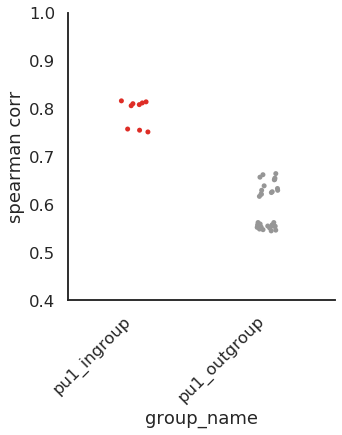

In [73]:
cp = sns.catplot(x="group_name",
            y="spearman corr",
            data=tidy_corr,
            aspect=1,
            # showmeans=True,
            palette=pal)

# fix x labels
cp.set_xticklabels(rotation=45, ha='right');
cp.set(ylim=[0.4,1])

Calculate pairwise signifiacnce of deviation

In [71]:
from scipy.stats import kruskal
kruskal(pu1_ingroup, pu1_outgroup)

KruskalResult(statistic=20.25, pvalue=6.795346249460114e-06)